# Intro to ML
## Workflow: Pipelines and Feature Unions
---

En la última sesión comentamos qué métricas nos permiten discriminar los modelos y cómo calcularlas con especial enfasis en métricas de clasificación.

En la sesión de hoy, haremos una mención especial a cómo tratar de forma programática las distintas fases de un trabajo o proyecto de modelización: transformación de los datos, afinado de hiper-parametros y validación.


A final del notebook deberíais entender como usar:

* Pipelines
* Feature Unions
* Custom transformers

## 1. Pipelines

Al encarar un proyecto de modelizado de datos, antes de poder utilizar un motor de predicción o clasificación, tendremos que *jugar* con los datos con dos objetivos:

1. Modificar/seleccionar las variables predictoras con tal de obtener las mejores predicciones
1. Alimentar el algoritmo de ML con un formato de datos que sea capaz de utilizar

Dicho de otra forma, los datos pasarán por una serie transformaciones y por último por un paso de modelizado.

Cada uno de los pasos de la secuencia puede ser definido como un **componente** y el flujo de transformación como una serie de **componentes** encadenados.

---

<img src='img/pipeline.png'>

---

A este tipo de proceso, aplicable a cualquier tipo de transformacion de datos o ETL, se lo conoce como Grafo Aciclico Dirigido o `DAG` por sus siglas en inglés. Dicho de mejor forma:

>**Data is immutable**
>
>Don't ever edit your raw data, especially not manually, and especially not in Excel. Don't overwrite your raw data. Don't save multiple versions of the raw data. Treat the data (and its format) as immutable. The code you write should move the raw data through a pipeline to your final analysis. You shouldn't have to run all of the steps every time you want to make a new figure (see Analysis is a DAG), but anyone should be able to reproduce the final products with only the code in src and the data in data/raw.
> 
> [Cookiecutter Data Science](https://drivendata.github.io/cookiecutter-data-science/#data-is-immutable) - A logical, reasonably standardized, but flexible project structure for doing and sharing data science work.

Si bien los DAGs pueden llegar a tal complejidad que se compongan de distintos procesos que requieren un orquestador que se encargue de ejecutarlos y monitorizarlos (e.g. el orquestador más popular actualmente es [Airflow](https://airflow.apache.org/), `sklearn` nos provee de una interfaz para crear pipelines sencilla.

Los `pipelines` de sklearn nos permiten encadenar los distintos transformers de sklearn, tanto de pre-procesado como de modelizado, de forma secuencial de forma que la salida de un componente sea la entrada del siguiente.

Las principales ventajas serán:
* Conveniencia y encapsulación: Solo se tendrán que utilizar los metodos `.fit` y `.predict` una vez dada la secuencia de estimadores.

* Selección de parametros conjunta: Podremos realizar el GridSearch no solo sobre los hiperparametros del parametro si no tambien sobre las distintas etapas de transformación previa (p. ej. numero de componentes de PCA a usar)

* Safety: Evita el "information leakeage" entre train y test aseugrandose que las mismas muestras son las que se usan en todas las etapas de transformación.


Preparamos los datos con unos cuantos nan's...

In [1]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd

data = load_iris()
X = data.data
y = data.target
### adding some nan's
mask = np.random.choice([0,1], p=[0.99, 0.01], size=X.shape).astype(np.bool)
X[mask] = np.nan

X = pd.DataFrame(X, columns=data['feature_names'])
y = pd.Series(y)

In [2]:
X.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
94,5.6,2.7,4.2,1.3
147,6.5,3.0,5.2,2.0
65,6.7,3.1,4.4,1.4
97,6.2,2.9,4.3,1.3
22,4.6,3.6,1.0,0.2


### Ejemplo de Pipeline

### Solo transformaciones

Los `transformers` de sklearn son aquellos que tienen los metodos de `fit_transform`. Podremos encadenar todos los que queramos siguiendo una secuencia de transformaciones.

En este ejemplo vemos como podemos encadenar:

1. Imputación de nulos
2. Normalización

Recordad que todas las transformaciones se ejecutarán sobre el subset `train`. De ésta forma, la media para imputación se calculará solo sobre el subset de entrenamiento y la usaremos para popular los nulos en el dataset de testeo. Esto se hace así para poder simular las condiciones de uso reales, donde las predicciones siempre serán "out of sample".

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

## Dividimos los datos en test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234, shuffle=True)

## Definimos los pasos del pipeline como tuplas (name, Transformer)
imputation_step = ('imputer', SimpleImputer(strategy='mean'))
scaling_step = ('scaler', StandardScaler())

## Los ordenamos en una lista
steps = [imputation_step, scaling_step]

## Finalmente llamamos al creador de pipeline
pipe = Pipeline(steps)

X_train_transformed = pipe.fit_transform(X_train)
X_test_transformed = pipe.transform(X_test)

print('X_train: \n')
print('Mean before pipeline: \n', X_train.mean())
print('Mean after pipeline: \n', X_train_transformed.mean(axis=0))

print('\n X_test: \n')
print('Mean before pipeline: \n', X_test.mean())
print('Mean after pipeline: \n', X_test_transformed.mean(axis=0))

X_train: 

Mean before pipeline: 
 sepal length (cm)    5.836000
sepal width (cm)     3.063636
petal length (cm)    3.792784
petal width (cm)     1.210101
dtype: float64
Mean after pipeline: 
 [ 7.63833441e-16 -1.60926827e-15  3.48610030e-16  2.48689958e-16]

 X_test: 

Mean before pipeline: 
 sepal length (cm)    5.858000
sepal width (cm)     3.059184
petal length (cm)    3.732000
petal width (cm)     1.196000
dtype: float64
Mean after pipeline: 
 [ 0.02783464 -0.00961679 -0.03573739 -0.01914127]


**Podemos acceder a los valores asignados a los atributos de cada `step` del pipeline por su nombre. Estos tendran los atributos del `transformer` utilizado.**

In [4]:
# valores de imputación utilizados
print(pipe['imputer'].statistics_)

[5.836      3.06363636 3.79278351 1.21010101]


In [5]:
X_train.mean()

sepal length (cm)    5.836000
sepal width (cm)     3.063636
petal length (cm)    3.792784
petal width (cm)     1.210101
dtype: float64

### Grid search sobre parametros de los transformadores

Una de las ventajas de usar un pipeline, es que podemos definir un gridsearch donde los parametros de busqueda incluyan aquellos de los transformadores. Vamos a ver si es mejor usar la media o la mediana...

In [6]:
import time

In [7]:
## Import pipeline
from sklearn.pipeline import Pipeline

## Import StandardScaler
from sklearn.preprocessing import StandardScaler

## Import SimpleImputer
from sklearn.impute import SimpleImputer

## Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

## Import GridSearch y train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

## Dividimos los datos en test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234, shuffle=True)

## Definimos los pasos del pipeline como tuplas (name, Transformer)
imputation_step = ('imputer', SimpleImputer())
scaling_step = ('scaler', StandardScaler())
model_step = ('clf', RandomForestClassifier())

## Los ordenamos en una lista
steps = [imputation_step, scaling_step, model_step]

## Finalmente llamamos al creador de pipeline
pipe = Pipeline(steps)


## Definimos el espacio de busqueda para el gridsearch.
## Podemos acceder a los distintos hiperparametros de los Transformadores como nombre__hiperparametro

param_grid = {'imputer__strategy': ['mean', 'median'],
              'clf__max_depth': [3, 5, 10, 15],
              'clf__min_samples_leaf': [2, 5, 10, 15]}

## usamos el pipe como estimador en el gridsearch
clf_gs = GridSearchCV(pipe, cv=3, n_jobs=-1, param_grid=param_grid, verbose=1)

clf_gs.fit(X_train, y_train)

time.sleep(1)

print('Best params: ', clf_gs.best_params_)
print('Best score: ', clf_gs.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    4.1s finished


Best params:  {'clf__max_depth': 15, 'clf__min_samples_leaf': 10, 'imputer__strategy': 'mean'}
Best score:  0.9598930481283423


**Para poder hacer predicciones, simplemente debemos llamar al clf_gs con el metodo predict.**
**El pipeline se encarga de hacer las transformaciones necesarias antes de pasarle los datos al predictor.**
Esto es ideal para la productivización de un modelo. Nos permite recoger el dato "crudo" y pasarlo por una sola clase donde se tengan en cuenta todas las transformaciones necesarias antes de pasarlo al modelo para hacer la predicción

In [8]:
y_test_pred = clf_gs.predict(X_test)

In [9]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.94      0.94      0.94        17
           2       0.94      0.94      0.94        16

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



---

#### Feature engineering usando Principal Component Analysis

En la última sesión vimos como el PCA podía usarse tanto como una tranformación `many to many` para evitar la colinearidad de algunos predictores y como seleccion de variables para reducir la dimensionalidad. 

Realizar PCA sobre un set de datos multidimensional nos permitirá:

1. Visualizar una proyección de los datos en 2-3 dimensiones
1. Eliminar colinearidad
1. Reducir el número de predictores: seleccionaremos un número límitado de componentes de forma que expliquemos la mayor parte de la varianza de los datos

Por ejemplo...

In [10]:
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

data = load_breast_cancer()

X = data.data
y = data.target

## Definimos los pasos del pipeline como tuplas (name, Transformer)
scaling_step = ('scaler', MinMaxScaler())
pca_step = ('pca', PCA())

## Los ordenamos en una lista
steps = [scaling_step, pca_step]

## Finalmente llamamos al creador de pipeline
pipe = Pipeline(steps)

X_pca = pipe.fit_transform(X)

Plot the results

Text(0.5, 1.0, 'Explained Variance')

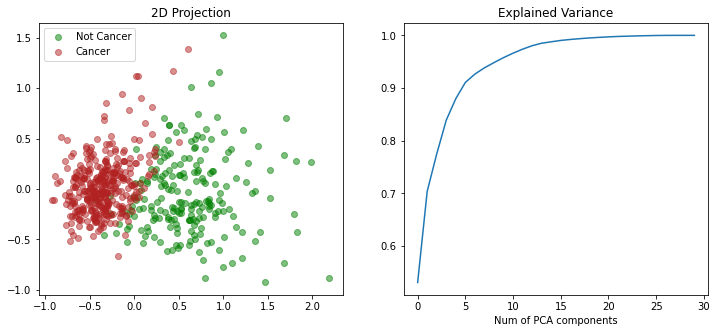

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

f, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].scatter(X_pca[y==0][:,0], X_pca[y==0][:, 1], c='green', alpha=0.5, label='Not Cancer')
ax[0].scatter(X_pca[y==1][:,0], X_pca[y==1][:, 1], c='firebrick', alpha=0.5, label='Cancer')
ax[0].legend(loc='upper left')
ax[0].set_title('2D Projection')
ax[1].plot(pipe['pca'].explained_variance_ratio_.cumsum())
ax[1].set_xlabel('Num of PCA components')
ax[1].set_title('Explained Variance')

---

### Ejercicio: Traduce el siguiente script a un pipeline y evalualo en el dataset de testeo.

Nota: En vez de seleccionar manualmente el umbral de varianza explicada para el PCA, introduce el número de componentes en el gridsearch del pipeline.

In [12]:
import pandas as pd
from sklearn.datasets import load_wine
data = load_wine()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['y'] = data.target

# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1), df.y,
                                                    test_size = 0.33, random_state=123)
###########################################
## Transformation 1: Polynomial Features ##
###########################################

from sklearn.preprocessing import PolynomialFeatures

#instantiate polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True)

# fit scaler to train data
poly.fit(X_train)

# scale X_train
X_train_poly= poly.transform(X_train)

#######################################
## Transformation 2: feature scaling ##
#######################################

## It is important to only to fit the transformer on the train dataset!
from sklearn.preprocessing import StandardScaler

# instantiate scaler
scaler = StandardScaler()

# fit scaler to train data
scaler.fit(X_train_poly)

# scale X_train
X_train_poly_scaled= scaler.transform(X_train_poly)

###########################
## Transformation 3: PCA ##
###########################

from sklearn.decomposition import PCA

# instantiate pca
pca = PCA()

# fit PCA to scaled train data
pca.fit(X_train_poly_scaled)

# scale X_train
X_train_poly_scaled_pca = pca.transform(X_train_poly_scaled)

#########################################
## Transformation 4: Feature Selection ##
#########################################

# Num of components needed to reach 95%
num_comp_95 = pca.explained_variance_ratio_[pca.explained_variance_ratio_.cumsum() < 0.95].shape[0]

# instantiate pca with number of components desired
pca = PCA(num_comp_95)

# refit PCA to scaled train data
pca.fit(X_train_poly_scaled)

# scale X_train
X_train_final = pca.transform(X_train_poly_scaled)

##################
## Modelization ##
##################

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## Define stratified kfold
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

## Instantiate Random Forest
clf_rf = RandomForestClassifier()

## set up a parameter grid for the gridsearch
params_clf_rf = {'max_depth': [2, 3, 4],
                 'min_samples_leaf': [8, 9, 10, 11, 12],
                 'min_samples_split': [3, 4, 5, 6, 7]}

## Instantiate the gridsearch
clf_gs = GridSearchCV(estimator=clf_rf, cv=skfold, param_grid=params_clf_rf, verbose=1, n_jobs=-1)

## Fit the gridsearch
clf_gs.fit(X_train_final, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    9.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4],
                         'min_samples_leaf': [8, 9, 10, 11, 12],
                         'min_samples_split': [3, 4, 5, 6, 7]},
             verbose=1)

### Solution

In [13]:
###########################################
## Transformation 1: Polynomial Features ##
###########################################

from sklearn.preprocessing import PolynomialFeatures

#instantiate polynomial features
step_poly = ('poly', PolynomialFeatures())

#######################################
## Transformation 2: feature scaling ##
#######################################

from sklearn.preprocessing import StandardScaler

step_scaler = ('scaler', StandardScaler())

###########################
## Transformation 3: PCA ##
###########################

from sklearn.decomposition import PCA

step_pca = ('pca', PCA())

##################
## Modelization ##
##################

from sklearn.ensemble import RandomForestClassifier

model_step = ('clf', RandomForestClassifier())

##########################
## Make pipe            ##
##########################
from sklearn.pipeline import Pipeline

pipe_steps = [step_poly, step_scaler, step_pca, model_step]
pipe = Pipeline(pipe_steps)


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

## Define stratified kfold
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

params_pipe = {'poly__degree': [2, 3],
               'pca__n_components': [9, 10, 11],
               'clf__max_depth': [3, 4],
               'clf__min_samples_leaf': [8, 9, 10],
               'clf__min_samples_split': [5, 6, 7]}

## Instantiate the gridsearch
clf_gs = GridSearchCV(pipe, cv=skfold, param_grid=params_pipe, verbose=1, n_jobs=-1)

## Fit the gridsearch
clf_gs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:    8.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [3, 4],
                         'clf__min_samples_leaf': [8, 9, 10],
                         'clf__min_samples_split': [5, 6, 7],
                         'pca__n_components': [9, 10, 11],
                         'poly__degree': [2, 3]},
             verbose=1)

In [14]:
print(clf_gs.best_estimator_.named_steps)

{'poly': PolynomialFeatures(), 'scaler': StandardScaler(), 'pca': PCA(n_components=10), 'clf': RandomForestClassifier(max_depth=3, min_samples_leaf=8, min_samples_split=7)}


In [15]:
y_test_pred = clf_gs.predict(X_test)

In [16]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        16
           1       0.85      0.81      0.83        21
           2       0.95      0.95      0.95        22

    accuracy                           0.88        59
   macro avg       0.88      0.88      0.88        59
weighted avg       0.88      0.88      0.88        59



## 2. Feature unions

Hasta ahora, solo hemos trabajado con un tipo de variables: númericas. Sin embargo, si tuvieramos variables categóricas, deberíamos tratarlas de forma distinta. Por ejemplo, haciendo un **OneHotEncoding**.

Las feature unions nos permiten trabajar con transformaciones según el tipo de variable, para despues unirlas antes de pasarlas al modelo de ML.

![feat-union](img/pipeline+featunion.png)

### Importamos el dataset con el que trabajaremos

In [17]:
import pandas as pd

data = pd.read_csv('data/abalone.csv',)

## Custom transformers

Con tal de poder interactuar con los `Pipelines`, sklearn nos da la opcion de crear nuestras propias transformaciones basandonos en su sintaxis.

Para esto crearemos una clase que herede el `TransformerMixin`. Al heredar esta clase, si creamos una que tenga los metodos `fit` y `transform` nos dará automaticamente un metodo que sea `fit_transform` y que sea compatible con el resto de la `suite` de sklearn.

Vamos a crear un `transformer` propio que nos devuelva las columnas elegidas durante la inicialización. Usaremos este `transformer` como primera etapa en el pipe de OHE para seleccionar la columna categorica

Vamos a crear otro `transformer` que nos haga lo contrario, que nos elimine la columna especificada.

De esta forma, podremos usar un solo punto de entrada al pipeline y será el pipeline el que se encargará de hacer la division entre variables numericas y categoricas, como en la imagen anterior

In [18]:
from sklearn.base import TransformerMixin

### aux functions

class SelectColumns(TransformerMixin):
    def __init__(self, columns: list) -> pd.DataFrame:
        if not isinstance(columns, list):
            raise ValueError('Specify the columns into a list')
        self.columns = columns
    def fit(self, X, y=None): # we do not need to specify the target in the transformer. We leave it as optional arg for consistency
        return self
    def transform(self, X):
        return X[self.columns]
    
class DropColumns(TransformerMixin):
    def __init__(self, columns: list) -> pd.DataFrame:
        if not isinstance(columns, list):
            raise ValueError('Specify the columns into a list')
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(self.columns, axis=1)

Vamos a probar...

In [19]:
sel_col = SelectColumns(['sex'])
sel_col.fit_transform(data)

,sex
0,M
1,M
2,F
3,M
4,I
...,...
4172,F
4173,M
4174,M
4175,F


In [20]:
drop_col = DropColumns(['sex'])
drop_col.fit_transform(data)

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,y_rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


**transformation to one-hot-encode 'sex' feature**

In [21]:
from sklearn.preprocessing import OneHotEncoder

select_col_step = ('select', SelectColumns(['sex']))

one_hot_step = ('sex_one_hot', OneHotEncoder(sparse=False))

cat_pipe_steps = [select_col_step, one_hot_step]

cat_pipe = Pipeline(cat_pipe_steps)

In [22]:
cat_pipe.fit_transform(data)

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [23]:
cat_pipe['sex_one_hot'].categories_

[array(['F', 'I', 'M'], dtype=object)]

**Transformation of the numeric values by MinMaxScaler**

In [24]:
from sklearn.preprocessing import MinMaxScaler

drop_column_step = ('drop_column', DropColumns(['sex']))

poly_step = ('poly', PolynomialFeatures(2,  interaction_only=True))

scaler_step = ('scaler', MinMaxScaler())

num_pipe_steps = [drop_column_step, poly_step, scaler_step]

num_pipe = Pipeline(num_pipe_steps)

**Join the two pipes using feature union**

In [25]:
from sklearn.pipeline import FeatureUnion

transformer_list = [('num_pipe', num_pipe),
                    ('cat_pipe', cat_pipe)]

full_pipe = FeatureUnion(transformer_list=transformer_list)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('y_rings', axis=1), data.y_rings, test_size=0.2)

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
reg = RandomForestRegressor()

In [29]:
X_train_trans = full_pipe.fit_transform(X_train)

In [30]:
reg.fit(X_train_trans, y_train)

RandomForestRegressor()

In [31]:
y_test_pred_pipe = reg.predict(full_pipe.transform(X_test))

In [32]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_test_pred_pipe))

1.5014234449760766


In [33]:
bins = y_test.unique().shape[0]

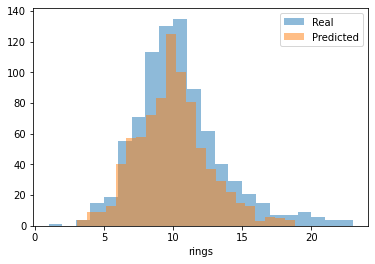

In [34]:
plt.hist(y_test, alpha=0.5, bins=bins, label='Real')
plt.hist(y_test_pred_pipe, alpha=0.5, bins=bins, label='Predicted')
plt.xlabel('rings')
plt.legend(loc='best')
plt.show()

Text(0, 0.5, 'Predicted Value')

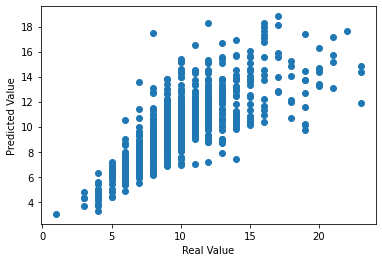

In [35]:
f, ax = plt.subplots()


ax.scatter(y_test, y_test_pred_pipe)
ax.set_xlabel('Real Value')
ax.set_ylabel('Predicted Value')

## Añade el random forest al pipeline

In [36]:
## numerical columns

drop_column_step = ('drop_column', DropColumns(['sex']))
poly_step = ('poly', PolynomialFeatures(2,  interaction_only=True))
scaler_step = ('scaler', MinMaxScaler())
num_pipe_steps = [drop_column_step, poly_step, scaler_step]
num_pipe = Pipeline(num_pipe_steps)

## Categorical columns

select_col_step = ('select', SelectColumns(['sex']))
one_hot_step = ('sex_one_hot', OneHotEncoder(sparse=False))
cat_pipe_steps = [select_col_step, one_hot_step]
cat_pipe = Pipeline(cat_pipe_steps)

## Modelling step

regressor_step = ('model', RandomForestRegressor())

## Compose Pipeline

### Feature uninon over numerical and categorical transformation

transformer_list = [('num_pipe', num_pipe),
                    ('cat_pipe', cat_pipe)]

data_prep_pipe = FeatureUnion(transformer_list=transformer_list)
data_prep_step = ('data_prep', data_prep_pipe)

### Compose full pipe: RandomForest over data_prep_pipe

pipe_steps = [data_prep_step, regressor_step]

pipe = Pipeline(pipe_steps)

In [37]:
## Review raw data
X_train

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
4129,I,0.570,0.425,0.140,0.7655,0.3310,0.1400,0.2400
2111,I,0.455,0.355,0.080,0.4520,0.2165,0.0995,0.1250
768,F,0.550,0.430,0.155,0.7850,0.2890,0.2270,0.2330
3246,M,0.550,0.435,0.160,0.9060,0.3420,0.2190,0.2950
945,M,0.470,0.365,0.120,0.6120,0.3270,0.1500,0.1400
...,...,...,...,...,...,...,...,...
3371,M,0.330,0.235,0.090,0.1630,0.0615,0.0340,0.0550
601,F,0.385,0.315,0.110,0.2860,0.1225,0.0635,0.0835
3337,I,0.660,0.525,0.180,1.6935,0.6025,0.4005,0.4200
2335,M,0.610,0.490,0.150,1.1030,0.4250,0.2025,0.3600


In [38]:
## train all pipeline from raw data
pipe.fit(X_train, y_train)

Pipeline(steps=[('data_prep',
                 FeatureUnion(transformer_list=[('num_pipe',
                                                 Pipeline(steps=[('drop_column',
                                                                  <__main__.DropColumns object at 0x7fb229945250>),
                                                                 ('poly',
                                                                  PolynomialFeatures(interaction_only=True)),
                                                                 ('scaler',
                                                                  MinMaxScaler())])),
                                                ('cat_pipe',
                                                 Pipeline(steps=[('select',
                                                                  <__main__.SelectColumns object at 0x7fb2299452d0>),
                                                                 ('sex_one_hot',
                              

In [39]:
## predict from raw data. Pipeline will be in charge of transformations
y_predict = pipe.predict(X_test)

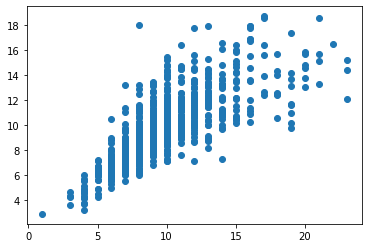

In [40]:
plt.scatter(y_test, y_predict)